In [1]:
import sys

!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install dagshub
!{sys.executable} -m pip install mlflow
!{sys.executable} -m pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
from scipy.stats import randint

In [3]:
# set up dagshub for mlflow tracking
import dagshub
dagshub.init(repo_owner='JonaKoenemann', repo_name='machine_failure_classification', mlflow=True)


Initialized MLflow to track repo "JonaKoenemann/machine_failure_classification"

Repository JonaKoenemann/machine_failure_classification initialized!

## Data preparation

In [4]:
data_path = "../../../data/predictive_maintenance.csv"

In [5]:
df = pd.read_csv(data_path)

In [6]:
categorical_features = ['Type']
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('UDI')
numerical_features.remove('Target')

# Feature Engineering: Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', poly)
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [7]:
# Split for features (X) und labels (y)
X = df[numerical_features + categorical_features] # select Features 
y = df["Failure Type"]

In [8]:
# Split for test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Test preprocessor pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(X_train_transformed.shape)
print(X_test_transformed.shape)

(8000, 23)
(2000, 23)


## Train and test

In [10]:
mlflow.set_experiment("random_forest_rs_feature")

mlflow.sklearn.autolog()

model = RandomForestClassifier(random_state=42)

# Define the parameters for RandomizedSearchCV
# param_distributions = {
#     'model__n_estimators': [100, 150, 200],
#     'model__max_depth': [None, 10, 20, 30],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4],
#     'model__bootstrap': [True, False]
# }
param_distributions = {
    'model__n_estimators': randint(100, 250),
    'model__max_depth': random.choice([None, randint(10, 30)]), # None or integer between 10 and 30
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__bootstrap': [True, False]
}

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# weighted f1 score as scoring metric
scorer = make_scorer(f1_score, average = "weighted")


In [11]:
with mlflow.start_run():    
    # Set up RandomizedSearchCV
    randomized_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                           n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring=scorer)

    # Fit RandomizedSearchCV
    randomized_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = randomized_search.best_params_
    mlflow.log_params(best_params)

    # Get the best model
    best_model = randomized_search.best_estimator_

    # predicition
    y_pred = best_model.predict(X_test)

    # evaluation
    weighted_f1 = f1_score(y_true = y_test, y_pred= y_pred, average="weighted")
    print("\nweighted f1 score:", weighted_f1)
    mlflow.log_metric('weighted_f1_score', weighted_f1)
    
    mlflow.end_run()


2024/06/21 19:46:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/06/21 19:47:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these colum

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024/06/21 19:52:39 WARNING mlflow.sklearn.utils: BaseSearchCV.score failed. The 'training_score' metric will not be recorded. Scoring error: pos_label=1 is not a valid label: It should be one of ['Heat Dissipation Failure' 'No Failure' 'O


weighted f1 score: 0.9771884013343598


## Evaluation

In [12]:
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure'] # get names of errors in correct order for confusion matrix

## Classification report

In [13]:
print("Classification Report:")
report = classification_report(y_test, y_pred)
print(report)

Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.90      0.60      0.72        15
              No Failure       0.98      1.00      0.99      1935
      Overstrain Failure       0.83      0.77      0.80        13
           Power Failure       0.88      0.70      0.78        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.60      0.51      0.55      2000
            weighted avg       0.97      0.98      0.98      2000



c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Normalized confusion matrix

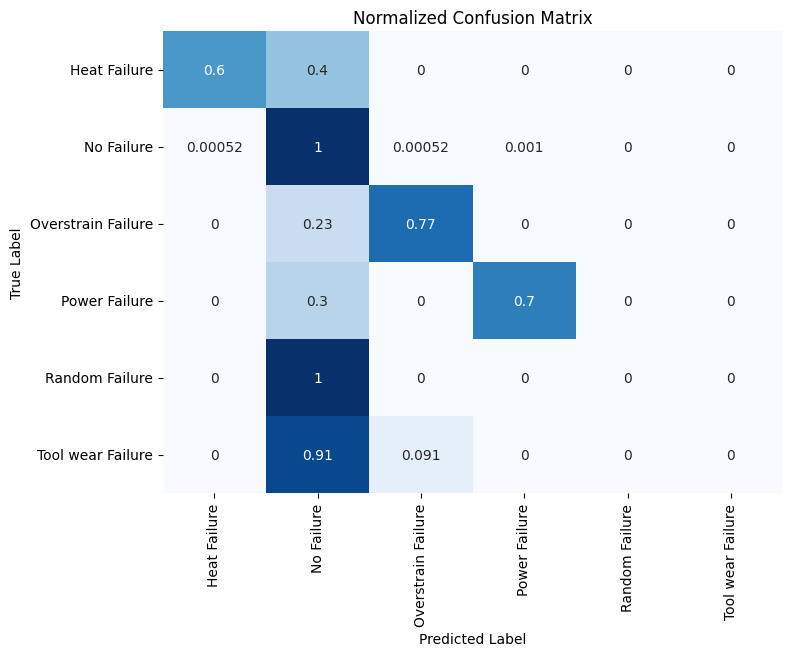

In [14]:
conf_matrix_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()
